#### Author: Adam Van Etten - June 2021


# Notebook for training, testing a model for SkyScan with YOLTv4

Apply YOLTv4 (https://github.com/cosmiq/yoltv4) to SkyScan data.

This notebook is assumed to be running in a the yoltv4 docker environment.

Download YOLO data from AWS instance:
    
    scp -i /xxx/skyscan.pem ubuntu@xxx.xxx.xxx.xxx:/home/ubuntu/SkyScan-Private/ml-model/dataset-export/322images-training.tar.gz .


Run notebooks on gpu08 with yoltv4_image
    
    cd /local_data/cosmiq/src/avanetten/yoltv4/docker
    nvidia-docker build -t yoltv4_image2 .
    nvidia-docker run -it -v /local_data/cosmiq/wdata/avanetten/skyscan/:/local_data/cosmiq/wdata/avanetten/skyscan/ -v /local_data/cosmiq/src/avanetten/yoltv4:/local_data/cosmiq/src/avanetten/yoltv4  -p 9119:9119 -ti --ipc=host --name yoltv4_skyscan yoltv4_image2

within docker on gpu08

    conda activate yoltv4
    cd /local_data/cosmiq/wdata/avanetten/skyscan/
    jupyter notebook --ip 0.0.0.0 --port=9119 --no-browser --allow-root &
    # locally in browser
    http://10.123.1.64:9119

In [8]:
from shapely.affinity import translate
from shapely.geometry import box
import matplotlib.pyplot as plt
from shapely.wkt import loads
from imp import reload
import geopandas as gpd
from tqdm import tqdm
import pandas as pd
import numpy as np
import collections
import skimage.io
import operator
import shapely
import random
import shutil
import time
import imp
import cv2
import sys
import os

yoltv4_path = '/local_data/cosmiq/src/avanetten/yoltv4/'
sys.path.append(os.path.join(yoltv4_path, 'yoltv4'))
import prep_train
import tile_ims_labels
import post_process
import eval
import eval_errors

# set dataset path
# gpu08
data_root = '/local_data/cosmiq/wdata/avanetten/skyscan/data/'

In [11]:
# Split some of the data into a test set.
# Since we are shuffling, make sure not to overwrite as we'll get duplicates...

input_dir = os.path.join(data_root, '322images-training/images')

train_dir = os.path.join(data_root, 'train')
test_dir = os.path.join(data_root, 'test')
if not os.path.exists(test_dir):
    for d in [train_dir, test_dir]:
        # os.makedirs(d, exist_ok=True)
        os.makedirs(os.path.join(d, 'images'))
        os.makedirs(os.path.join(d, 'labels'))

    im_list = sorted([z for z in os.listdir(input_dir) if z.endswith('.jpg')])
    # put 20% of the images in test
    N_test = int(0.20 * len(im_list))
    print("N_test:", N_test)

    test_im_set = set(random.sample(im_list, N_test))

    # move items to appropriate directory
    for im_name in im_list:
        im_path = os.path.join(input_dir, im_name)
        label_path = os.path.join(input_dir, im_name.split('.')[0] + '.txt')
        if im_name in test_im_set:
            # copy image and label
            shutil.copy(im_path, os.path.join(test_dir, 'images'))
            shutil.copy(label_path, os.path.join(test_dir, 'labels'))
        else:
            # copy image and label
            shutil.copy(im_path, os.path.join(train_dir, 'images'))
            shutil.copy(label_path, os.path.join(train_dir, 'labels'))

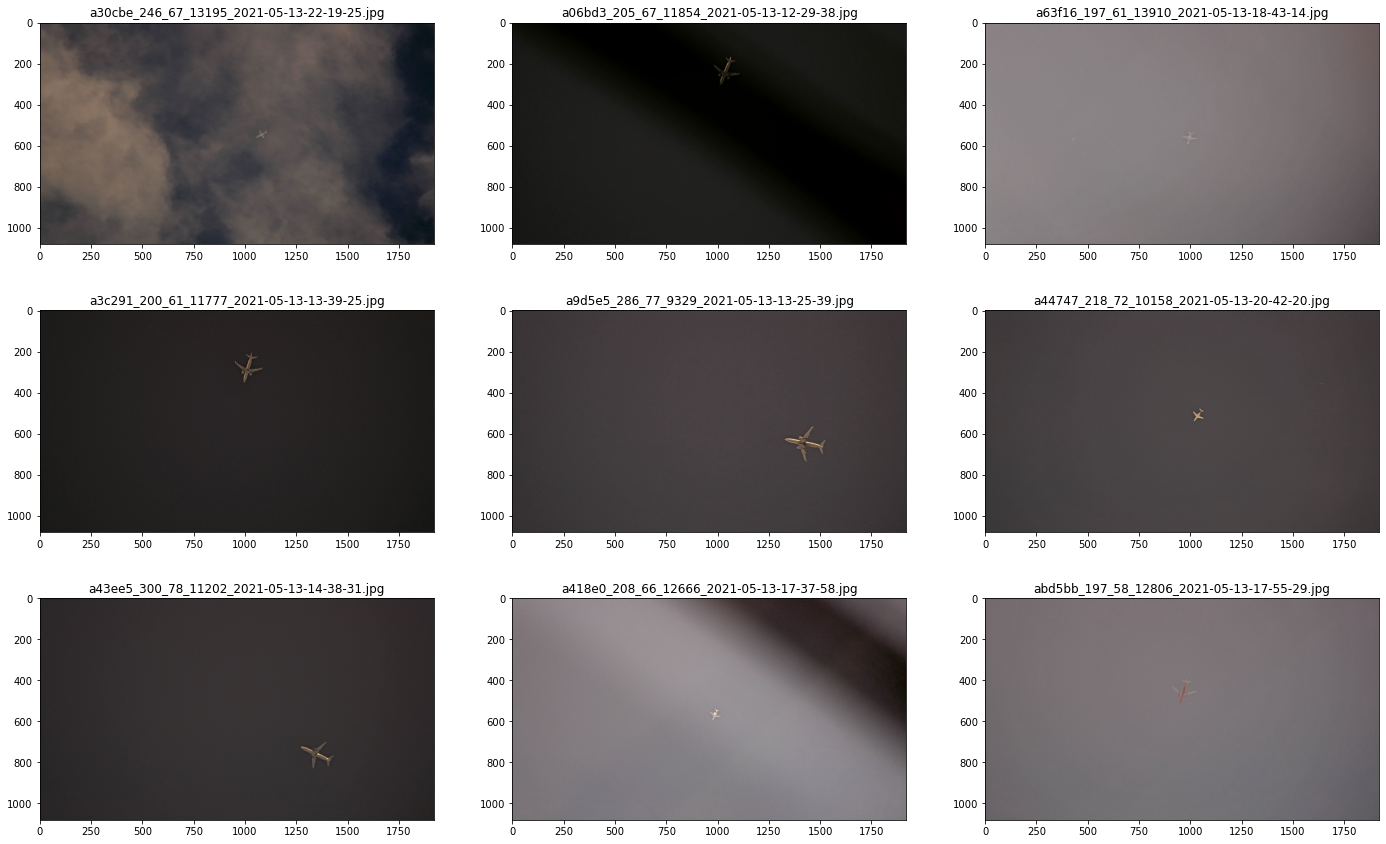

In [12]:
# Visualize some of the raw training iages
dir_tmp = outdir_ims
rows, cols = 3, 3
figsize = 8, 5
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp) if j.endswith('.jpg')]
rand_selection = paths_tmp[:rows*cols] #random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize[0]*cols, figsize[1]*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

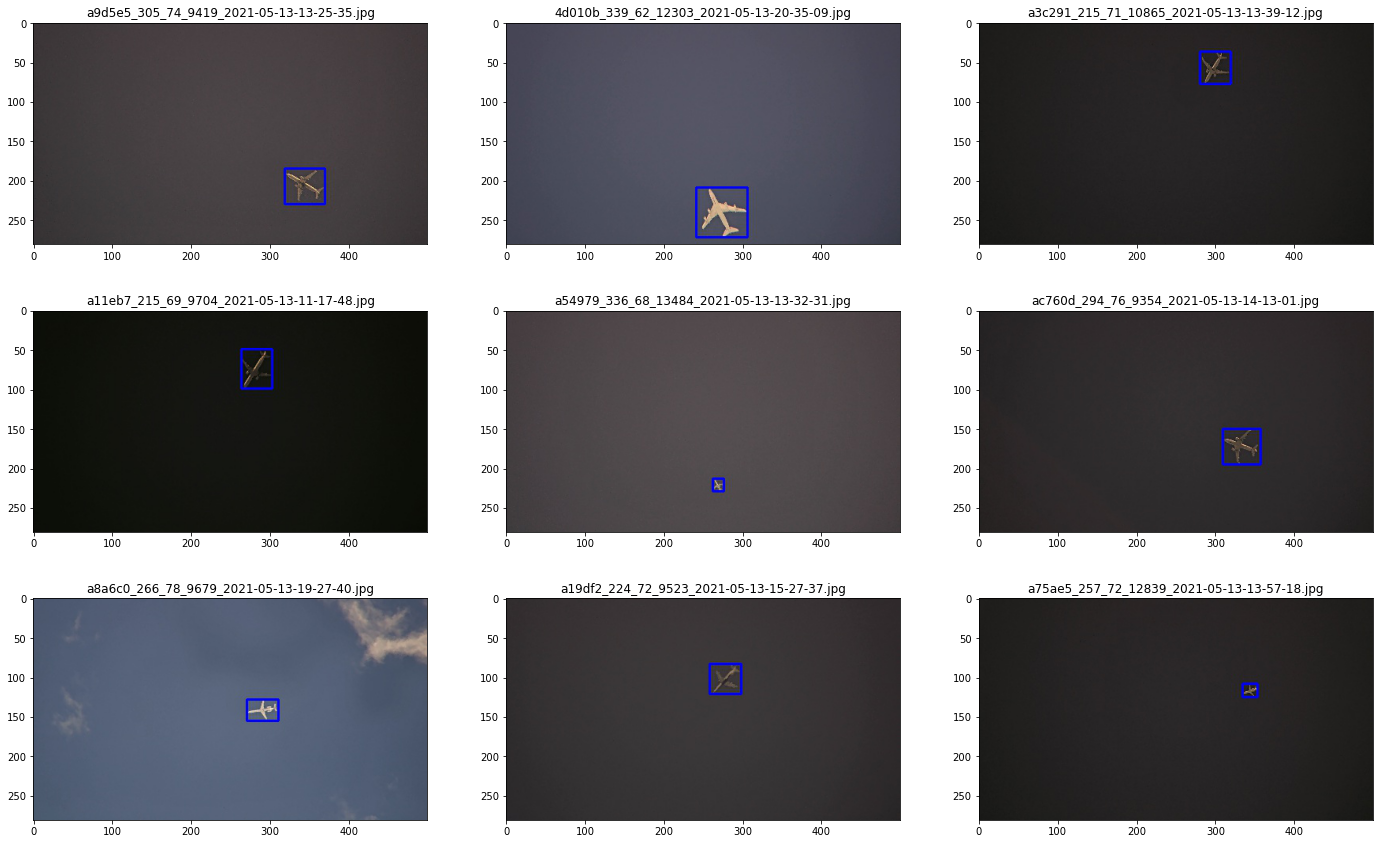

In [13]:
# Make some plots of the training bboxes.  This serves as a check to ensure that
# the YOLO labels are in the correct format.
outdir_ims = os.path.join(data_root, 'train', 'images')
outdir_labels = os.path.join(data_root, 'train', 'labels')
outdir_yolt_plots = os.path.join(data_root, 'train', 'yolt_plot_bboxes')
max_plots = 12
shuffle = False

# Make plots of training labels
prep_train.plot_training_bboxes(outdir_labels, outdir_ims, 
                 ignore_augment=True,
                 figsize=(10,10), color=(0,0,255), thickness=2, 
                 max_plots=max_plots, sample_label_vis_dir=outdir_yolt_plots,
                 ext='.jpg', show_plot=False, 
                 specific_labels=[], label_dic=[], output_width=500,
                 shuffle=shuffle, verbose=False) 

# Visualize some of the labels 
dir_tmp = outdir_yolt_plots
rows, cols = 3, 3
figsize = 8, 5
paths_tmp = [os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp)]
rand_selection = paths_tmp[:rows*cols] #random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize[0]*cols, figsize[1]*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

----------
## Prep data for yoltv4, for nauseating detail see:

    https://github.com/cosmiq/yoltv4
    https://github.com/AlexeyAB/darknet
       
Put .names and .data in: 

    /local_data/cosmiq/src/avanetten/yoltv4/darknet/data
   

### Make .names (list of names for each category, in a file, in darknet/data)

In [14]:
# make pre_train.names
name = 'aircraft'
outfile = '/local_data/cosmiq/src/avanetten/yoltv4/darknet/data/skyscan_binary.name'
!echo {name} > {outfile}
# cmd = 'echo ' + name + ' > ' + outfile
# os.system(cmd)

!cat {outfile}

# copy to data dir as well
outdir_txt = os.path.join(data_root, 'txt')
os.makedirs(outdir_txt, exist_ok=True)
!cp {outfile} {outdir_txt}

aircraft


### Create list of training, validation images (for use in .data file)

In [15]:
# pre_train
valid_iter = 5   # means every nth item is in valid set

outdir_txt = os.path.join(data_root, 'txt')
os.makedirs(outdir_txt, exist_ok=True)

outpath_train_list = os.path.join(outdir_txt, 'skyscan_binary_train.txt')
outpath_valid_list = os.path.join(outdir_txt, 'skyscan_binary_valid.txt')

# yolt outputs
outdir_ims = os.path.join(data_root, 'train', 'images')
outdir_labels = os.path.join(data_root, 'train', 'labels')
print("outdir_ims:", outdir_ims)

im_list_tot = sorted([os.path.join(outdir_ims, z) for z in os.listdir(outdir_ims) if z.endswith('.jpg')])
print("len im_list_tot:", len(im_list_tot))
print("im_list_tot[:5]:", im_list_tot[:5])

# make train and valid_list
im_list_train, im_list_valid = [], []
for i, im_path in enumerate(im_list_tot):
    if (i % valid_iter) == 0:
        im_list_valid.append(im_path)
    else:
        im_list_train.append(im_path)
print("len im_list_train:", len(im_list_train))
print("len im_list_valid:", len(im_list_valid))

# create txt files of image paths
for list_tmp, outpath_tmp in [[im_list_train, outpath_train_list], [im_list_valid, outpath_valid_list]]:
    df_tmp = pd.DataFrame({'image': list_tmp})
    df_tmp.to_csv(outpath_tmp, header=False, index=False)

print("head", outpath_tmp, "...")
!head {outpath_tmp}

outdir_ims: /local_data/cosmiq/wdata/avanetten/skyscan/data/train/images
len im_list_tot: 258
im_list_tot[:5]: ['/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/06a080_219_72_10508_2021-05-13-19-46-20.jpg', '/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/06a080_326_69_10665_2021-05-13-19-46-00.jpg', '/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/4850ad_114_72_7953_2021-05-13-17-31-31.jpg', '/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/4850ad_152_57_8986_2021-05-13-17-31-52.jpg', '/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/4850ad_156_52_9540_2021-05-13-17-32-00.jpg']
len im_list_train: 206
len im_list_valid: 52
head /local_data/cosmiq/wdata/avanetten/skyscan/data/txt/skyscan_binary_valid.txt ...
/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/06a080_219_72_10508_2021-05-13-19-46-20.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/train/images/4850ad_21_51_9634_2021-05-13-17-30-49.jpg
/local_data/

### Create .data files

Create file _.data in the directory build\darknet\x64\data\

Should look something like:

    classes = 1
    train  = /wdata/train.txt
    valid  = /wdata/valid.txt
    names = data/fun.names
    backup = backup/

In [16]:
# train
pops = ['train']
outnames = ['skyscan_binary']
classes = [1]
for pop,outname,class_num in zip(pops, outnames, classes):
    outname_tot = outname + '_' + pop
    outfile = '/local_data/cosmiq/src/avanetten/yoltv4/darknet/data/{}.data'.format(outname_tot)
    namefile = '/local_data/cosmiq/src/avanetten/yoltv4/darknet/data/{}.name'.format(outname)

    outdir_txt = os.path.join(data_root, 'txt')
    name_file = os.path.join(outdir_txt, 'rareplanes_{}.name'.format(pop))
    
    outpath_train_list = os.path.join(outdir_txt, outname + '_train.txt') 
    outpath_valid_list = os.path.join(outdir_txt, outname + '_valid.txt') 
        
    !echo 'classes = ' {class_num} > {outfile}
    !echo 'train = ' {outpath_train_list} >> {outfile}
    !echo 'valid = ' {outpath_valid_list} >> {outfile}
    !echo 'names = ' {namefile} >> {outfile}
    !echo 'backup = backup/' >> {outfile}

    print("\nhead:", outfile)
    !cat {outfile}


head: /local_data/cosmiq/src/avanetten/yoltv4/darknet/data/skyscan_binary_train.data
classes =  1
train =  /local_data/cosmiq/wdata/avanetten/skyscan/data/txt/skyscan_binary_train.txt
valid =  /local_data/cosmiq/wdata/avanetten/skyscan/data/txt/skyscan_binary_valid.txt
names =  /local_data/cosmiq/src/avanetten/yoltv4/darknet/data/skyscan_binary.name
backup = backup/


### Copy labels to image dir

For yolov4, images need to be in the same folder as images for training

In [17]:
outdir_ims = os.path.join(data_root, 'train', 'images')
outdir_labels = os.path.join(data_root, 'train', 'labels')
# copy
for f in os.listdir(outdir_labels):
    if f.endswith('.txt'):
        shutil.copy(os.path.join(outdir_labels, f), outdir_ims)

## Prepare testing data...

In [18]:
outdir_ims = os.path.join(data_root, 'test', 'images')
outpath_test_list = os.path.join(outdir_txt, 'skyscan_binary_test.txt')

#################
# make list of test files
im_list_test = []
for f in sorted([z for z in os.listdir(outdir_ims) if z.endswith('.jpg')]):
    im_list_test.append(os.path.join(outdir_ims, f))
df_tmp = pd.DataFrame({'image': im_list_test})
df_tmp.to_csv(outpath_test_list, header=False, index=False)
print("N test ims:", len(df_tmp))
!head {outpath_test_list}

#################
# create .data file
pops = ['test']
outnames = ['skyscan_binary']
classes = [1]
for pop,outname,class_num in zip(pops, outnames, classes):
    outname_tot = outname + '_' + pop
    outfile = '/local_data/cosmiq/src/avanetten/yoltv4/darknet/data/{}.data'.format(outname_tot)
    namefile = '/local_data/cosmiq/src/avanetten/yoltv4/darknet/data/{}.name'.format(outname)

    outdir_txt = os.path.join(data_root, 'txt')
    name_file = os.path.join(outdir_txt, 'rareplanes_{}.name'.format(pop))
    
    outpath_train_list = ''
    outpath_valid_list = os.path.join(outdir_txt, outname + '_test.txt') 
        
    !echo 'classes = ' {class_num} > {outfile}
    !echo 'train = ' {outpath_train_list} >> {outfile}
    !echo 'valid = ' {outpath_valid_list} >> {outfile}
    !echo 'names = ' {namefile} >> {outfile}
    !echo 'backup = backup/' >> {outfile}

    print("\nhead:", outfile)
    !cat {outfile}

N test ims: 67
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/06a080_334_65_11035_2021-05-13-19-45-56.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/4850ad_135_67_8206_2021-05-13-17-31-39.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/4d010b_205_67_11833_2021-05-13-20-35-51.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/4d010b_208_68_11682_2021-05-13-20-35-49.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/4d010b_307_77_11181_2021-05-13-20-35-26.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/_a418e0_213_68_12413_2021-05-13-17-37-54.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/_a4417d_191_49_15157_2021-05-13-12-02-25.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/_a63f16_211_73_12771_2021-05-13-18-42-56.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/test/images/a10614_215_64_8056_2021-05-13-20-27-04.jpg
/local_data/cosmiq/wdata/avanetten/skyscan/data/

-----
## Data is now prepped, so proceed with setting up the cfg file and launching training

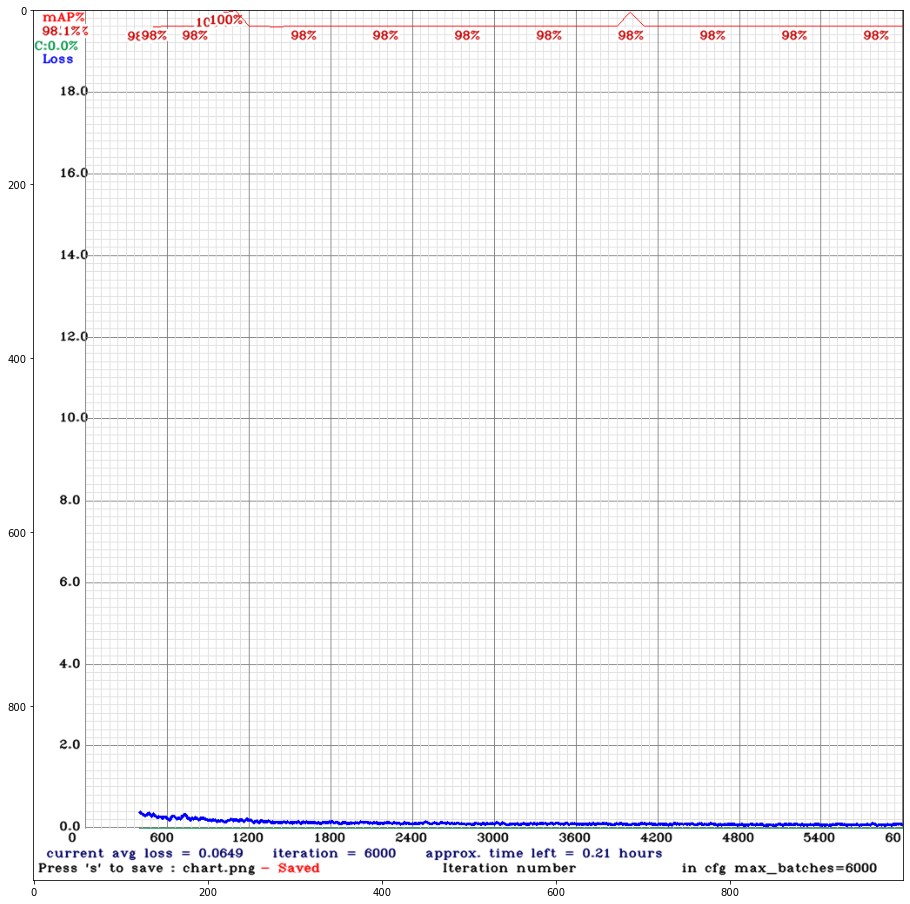

In [19]:
# view progress
f = '/local_data/cosmiq/src/avanetten/yoltv4/darknet/chart_yoltv4_skyscan_binary.png'
fig, ax = plt.subplots(figsize=(16,16))
ax.imshow(skimage.io.imread(f))

------
------
## Test

See src/detector.c lines 1943+ for testing options

In [9]:
# post process
reload(post_process)

detection_threshes = [0.1, 0.2, 0.3, 0.4, 0.5]
slice_size = 0
n_plots = 24
im_ext='.jpg'
allow_nested_detections = True
raw_im_dir = os.path.join(data_root, 'test/images')
sliced_im_dir = ''  # os.path.join(data_root, 'test/yoltv4/images_slice')
truth_file_name = ''  # 'rareplanes_test_ims_pre_train.geojson'
outnames = [
            'skyscan_binary' 
           ]
print("N test images:", len([z for z in os.listdir(raw_im_dir) if z.endswith(im_ext)]))
for outname in outnames:
    for detection_thresh in detection_threshes:
        out_csv = 'preds_refine_' + str(detection_thresh).replace('.', 'p') + '.csv'
        out_geojson_geo_dir = 'geojsons_geo_' + str(detection_thresh).replace('.', 'p')
        out_geojson_pix_dir = 'geojsons_pix_' + str(detection_thresh).replace('.', 'p')
        plot_dir = 'pred_plots_' + str(detection_thresh).replace('.', 'p')
        pred_txt_prefix = outname + '_'
        out_dir_root = os.path.join(yoltv4_path, 'darknet', 'results', outname)
        pred_dir = os.path.join(out_dir_root, 'orig_txt')
        truth_file = '' # os.path.join(data_root, 'test', 'geojsons_pix_comb', truth_file_name)

        # move raw predictions to output dir
        os.makedirs(os.path.join(out_dir_root, 'orig_txt'), exist_ok=True)
        !mv {yoltv4_path}/darknet/results/{outname}*.txt {out_dir_root}/orig_txt/

        # post_process
        post_process.execute(
            pred_dir=pred_dir,
            truth_file=truth_file,
            raw_im_dir=raw_im_dir,
            sliced_im_dir=sliced_im_dir,
            out_dir_root=out_dir_root,
            im_ext=im_ext,
            out_csv=out_csv,
            out_geojson_geo_dir=out_geojson_geo_dir,
            out_geojson_pix_dir=out_geojson_pix_dir,
            plot_dir=plot_dir,
            allow_nested_detections=allow_nested_detections,
            slice_size=slice_size,
            sep='__',
            pred_txt_prefix=pred_txt_prefix,
            n_plots=n_plots,
            detection_thresh=detection_thresh)

N test images: 67
mv: cannot stat '/local_data/cosmiq/src/avanetten/yoltv4//darknet/results/skyscan_binary*.txt': No such file or directory
df_raw.head:                                    im_name      prob         Xmin        Ymin  \
0  06a080_334_65_11035_2021-05-13-19-45-56  0.999788   964.574219  436.548584   
1  06a080_334_65_11035_2021-05-13-19-45-56  0.219682  1749.113281  849.493286   
2  06a080_334_65_11035_2021-05-13-19-45-56  0.002976     1.000000  483.880981   
3  06a080_334_65_11035_2021-05-13-19-45-56  0.001511  1878.272583   77.508224   
4  06a080_334_65_11035_2021-05-13-19-45-56  0.001183     5.855331  513.890381   

          Xmax         Ymax  category  
0  1218.537109   701.001465  aircraft  
1  1920.000000  1074.380249  aircraft  
2   110.962227   729.065918  aircraft  
3  1920.000000   198.869644  aircraft  
4   129.379211   765.318970  aircraft  
Augmenting dataframe of initial length: 70 ...
0
Time to augment dataframe of length: 70 = 0.016242504119873047 seconds


Making output plot...


/opt/conda/envs/yoltv4/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1 / 67 4850ad_135_67_8206_2021-05-13-17-31-39
n boxes: 1
Creating prediction geojson...
Making output plot...
2 / 67 4d010b_205_67_11833_2021-05-13-20-35-51
n boxes: 1
Creating prediction geojson...
Making output plot...
3 / 67 4d010b_208_68_11682_2021-05-13-20-35-49
n boxes: 1
Creating prediction geojson...
Making output plot...
4 / 67 4d010b_307_77_11181_2021-05-13-20-35-26
n boxes: 1
Creating prediction geojson...
Making output plot...
5 / 67 _a418e0_213_68_12413_2021-05-13-17-37-54
n boxes: 1
Creating prediction geojson...
Making output plot...
6 / 67 _a4417d_191_49_15157_2021-05-13-12-02-25
Making output plot...
7 / 67 _a63f16_211_73_12771_2021-05-13-18-42-56
n boxes: 1
Creating prediction geojson...
Making output plot...
8 / 67 a10614_215_64_8056_2021-05-13-20-27-04
n boxes: 1
Creating prediction geojson...
Making output plot...
9 / 67 a10614_292_73_7596_2021-05-13-20-26-48
n boxes: 1
Creating prediction geojson...
Making output plot...
10 / 67 a11eb7_207_64_10039_2021-05-13-11-1

  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 2
  non-max suppression final boxes: 2
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max 

/opt/conda/envs/yoltv4/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2 / 67 4d010b_205_67_11833_2021-05-13-20-35-51
n boxes: 1
Creating prediction geojson...
Making output plot...
3 / 67 4d010b_208_68_11682_2021-05-13-20-35-49
n boxes: 1
Creating prediction geojson...
Making output plot...
4 / 67 4d010b_307_77_11181_2021-05-13-20-35-26
n boxes: 1
Creating prediction geojson...
Making output plot...
5 / 67 _a418e0_213_68_12413_2021-05-13-17-37-54
n boxes: 1
Creating prediction geojson...
Making output plot...
6 / 67 _a4417d_191_49_15157_2021-05-13-12-02-25
Making output plot...
7 / 67 _a63f16_211_73_12771_2021-05-13-18-42-56
n boxes: 1
Creating prediction geojson...
Making output plot...
8 / 67 a10614_215_64_8056_2021-05-13-20-27-04
n boxes: 1
Creating prediction geojson...
Making output plot...
9 / 67 a10614_292_73_7596_2021-05-13-20-26-48
n boxes: 1
Creating prediction geojson...
Making output plot...
10 / 67 a11eb7_207_64_10039_2021-05-13-11-17-53
n boxes: 1
Creating prediction geojson...
Making output plot...
11 / 67 a14d8b_248_79_11749_2021-05-13-19

Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max sup

1 / 67 4850ad_135_67_8206_2021-05-13-17-31-39
n boxes: 1
Creating prediction geojson...
Making output plot...


/opt/conda/envs/yoltv4/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2 / 67 4d010b_205_67_11833_2021-05-13-20-35-51
n boxes: 1
Creating prediction geojson...
Making output plot...
3 / 67 4d010b_208_68_11682_2021-05-13-20-35-49
n boxes: 1
Creating prediction geojson...
Making output plot...
4 / 67 4d010b_307_77_11181_2021-05-13-20-35-26
n boxes: 1
Creating prediction geojson...
Making output plot...
5 / 67 _a418e0_213_68_12413_2021-05-13-17-37-54
n boxes: 1
Creating prediction geojson...
Making output plot...
6 / 67 _a4417d_191_49_15157_2021-05-13-12-02-25
Making output plot...
7 / 67 _a63f16_211_73_12771_2021-05-13-18-42-56
n boxes: 1
Creating prediction geojson...
Making output plot...
8 / 67 a10614_215_64_8056_2021-05-13-20-27-04
n boxes: 1
Creating prediction geojson...
Making output plot...
9 / 67 a10614_292_73_7596_2021-05-13-20-26-48
n boxes: 1
Creating prediction geojson...
Making output plot...
10 / 67 a11eb7_207_64_10039_2021-05-13-11-17-53
n boxes: 1
Creating prediction geojson...
Making output plot...
11 / 67 a14d8b_248_79_11749_2021-05-13-19

Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max sup

Making output plot...


/opt/conda/envs/yoltv4/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


1 / 67 4850ad_135_67_8206_2021-05-13-17-31-39
n boxes: 1
Creating prediction geojson...
Making output plot...
2 / 67 4d010b_205_67_11833_2021-05-13-20-35-51
n boxes: 1
Creating prediction geojson...
Making output plot...
3 / 67 4d010b_208_68_11682_2021-05-13-20-35-49
n boxes: 1
Creating prediction geojson...
Making output plot...
4 / 67 4d010b_307_77_11181_2021-05-13-20-35-26
n boxes: 1
Creating prediction geojson...
Making output plot...
5 / 67 _a418e0_213_68_12413_2021-05-13-17-37-54
n boxes: 1
Creating prediction geojson...
Making output plot...
6 / 67 _a4417d_191_49_15157_2021-05-13-12-02-25
Making output plot...
7 / 67 _a63f16_211_73_12771_2021-05-13-18-42-56
n boxes: 1
Creating prediction geojson...
Making output plot...
8 / 67 a10614_215_64_8056_2021-05-13-20-27-04
n boxes: 1
Creating prediction geojson...
Making output plot...
9 / 67 a10614_292_73_7596_2021-05-13-20-26-48
n boxes: 1
Creating prediction geojson...
Making output plot...
10 / 67 a11eb7_207_64_10039_2021-05-13-11-1

Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max suppression init boxes: 1
  non-max suppression final boxes: 1
Executing non-max suppression...
  non-max sup

1 / 67 4850ad_135_67_8206_2021-05-13-17-31-39
n boxes: 1
Creating prediction geojson...
Making output plot...


/opt/conda/envs/yoltv4/lib/python3.7/site-packages/rasterio/__init__.py:220: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix be returned.
  s = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


2 / 67 4d010b_205_67_11833_2021-05-13-20-35-51
n boxes: 1
Creating prediction geojson...
Making output plot...
3 / 67 4d010b_208_68_11682_2021-05-13-20-35-49
n boxes: 1
Creating prediction geojson...
Making output plot...
4 / 67 4d010b_307_77_11181_2021-05-13-20-35-26
n boxes: 1
Creating prediction geojson...
Making output plot...
5 / 67 _a418e0_213_68_12413_2021-05-13-17-37-54
n boxes: 1
Creating prediction geojson...
Making output plot...
6 / 67 _a4417d_191_49_15157_2021-05-13-12-02-25
Making output plot...
7 / 67 _a63f16_211_73_12771_2021-05-13-18-42-56
n boxes: 1
Creating prediction geojson...
Making output plot...
8 / 67 a10614_215_64_8056_2021-05-13-20-27-04
n boxes: 1
Creating prediction geojson...
Making output plot...
9 / 67 a10614_292_73_7596_2021-05-13-20-26-48
n boxes: 1
Creating prediction geojson...
Making output plot...
10 / 67 a11eb7_207_64_10039_2021-05-13-11-17-53
n boxes: 1
Creating prediction geojson...
Making output plot...
11 / 67 a14d8b_248_79_11749_2021-05-13-19

plot_dir: /local_data/cosmiq/src/avanetten/yoltv4/darknet/results/skyscan_binary/pred_plots_0p5
output plot file: /local_data/cosmiq/src/avanetten/yoltv4/darknet/results/skyscan_binary/yoltv4_test_set_prediction_mosaic_thresh=0p5.jpg


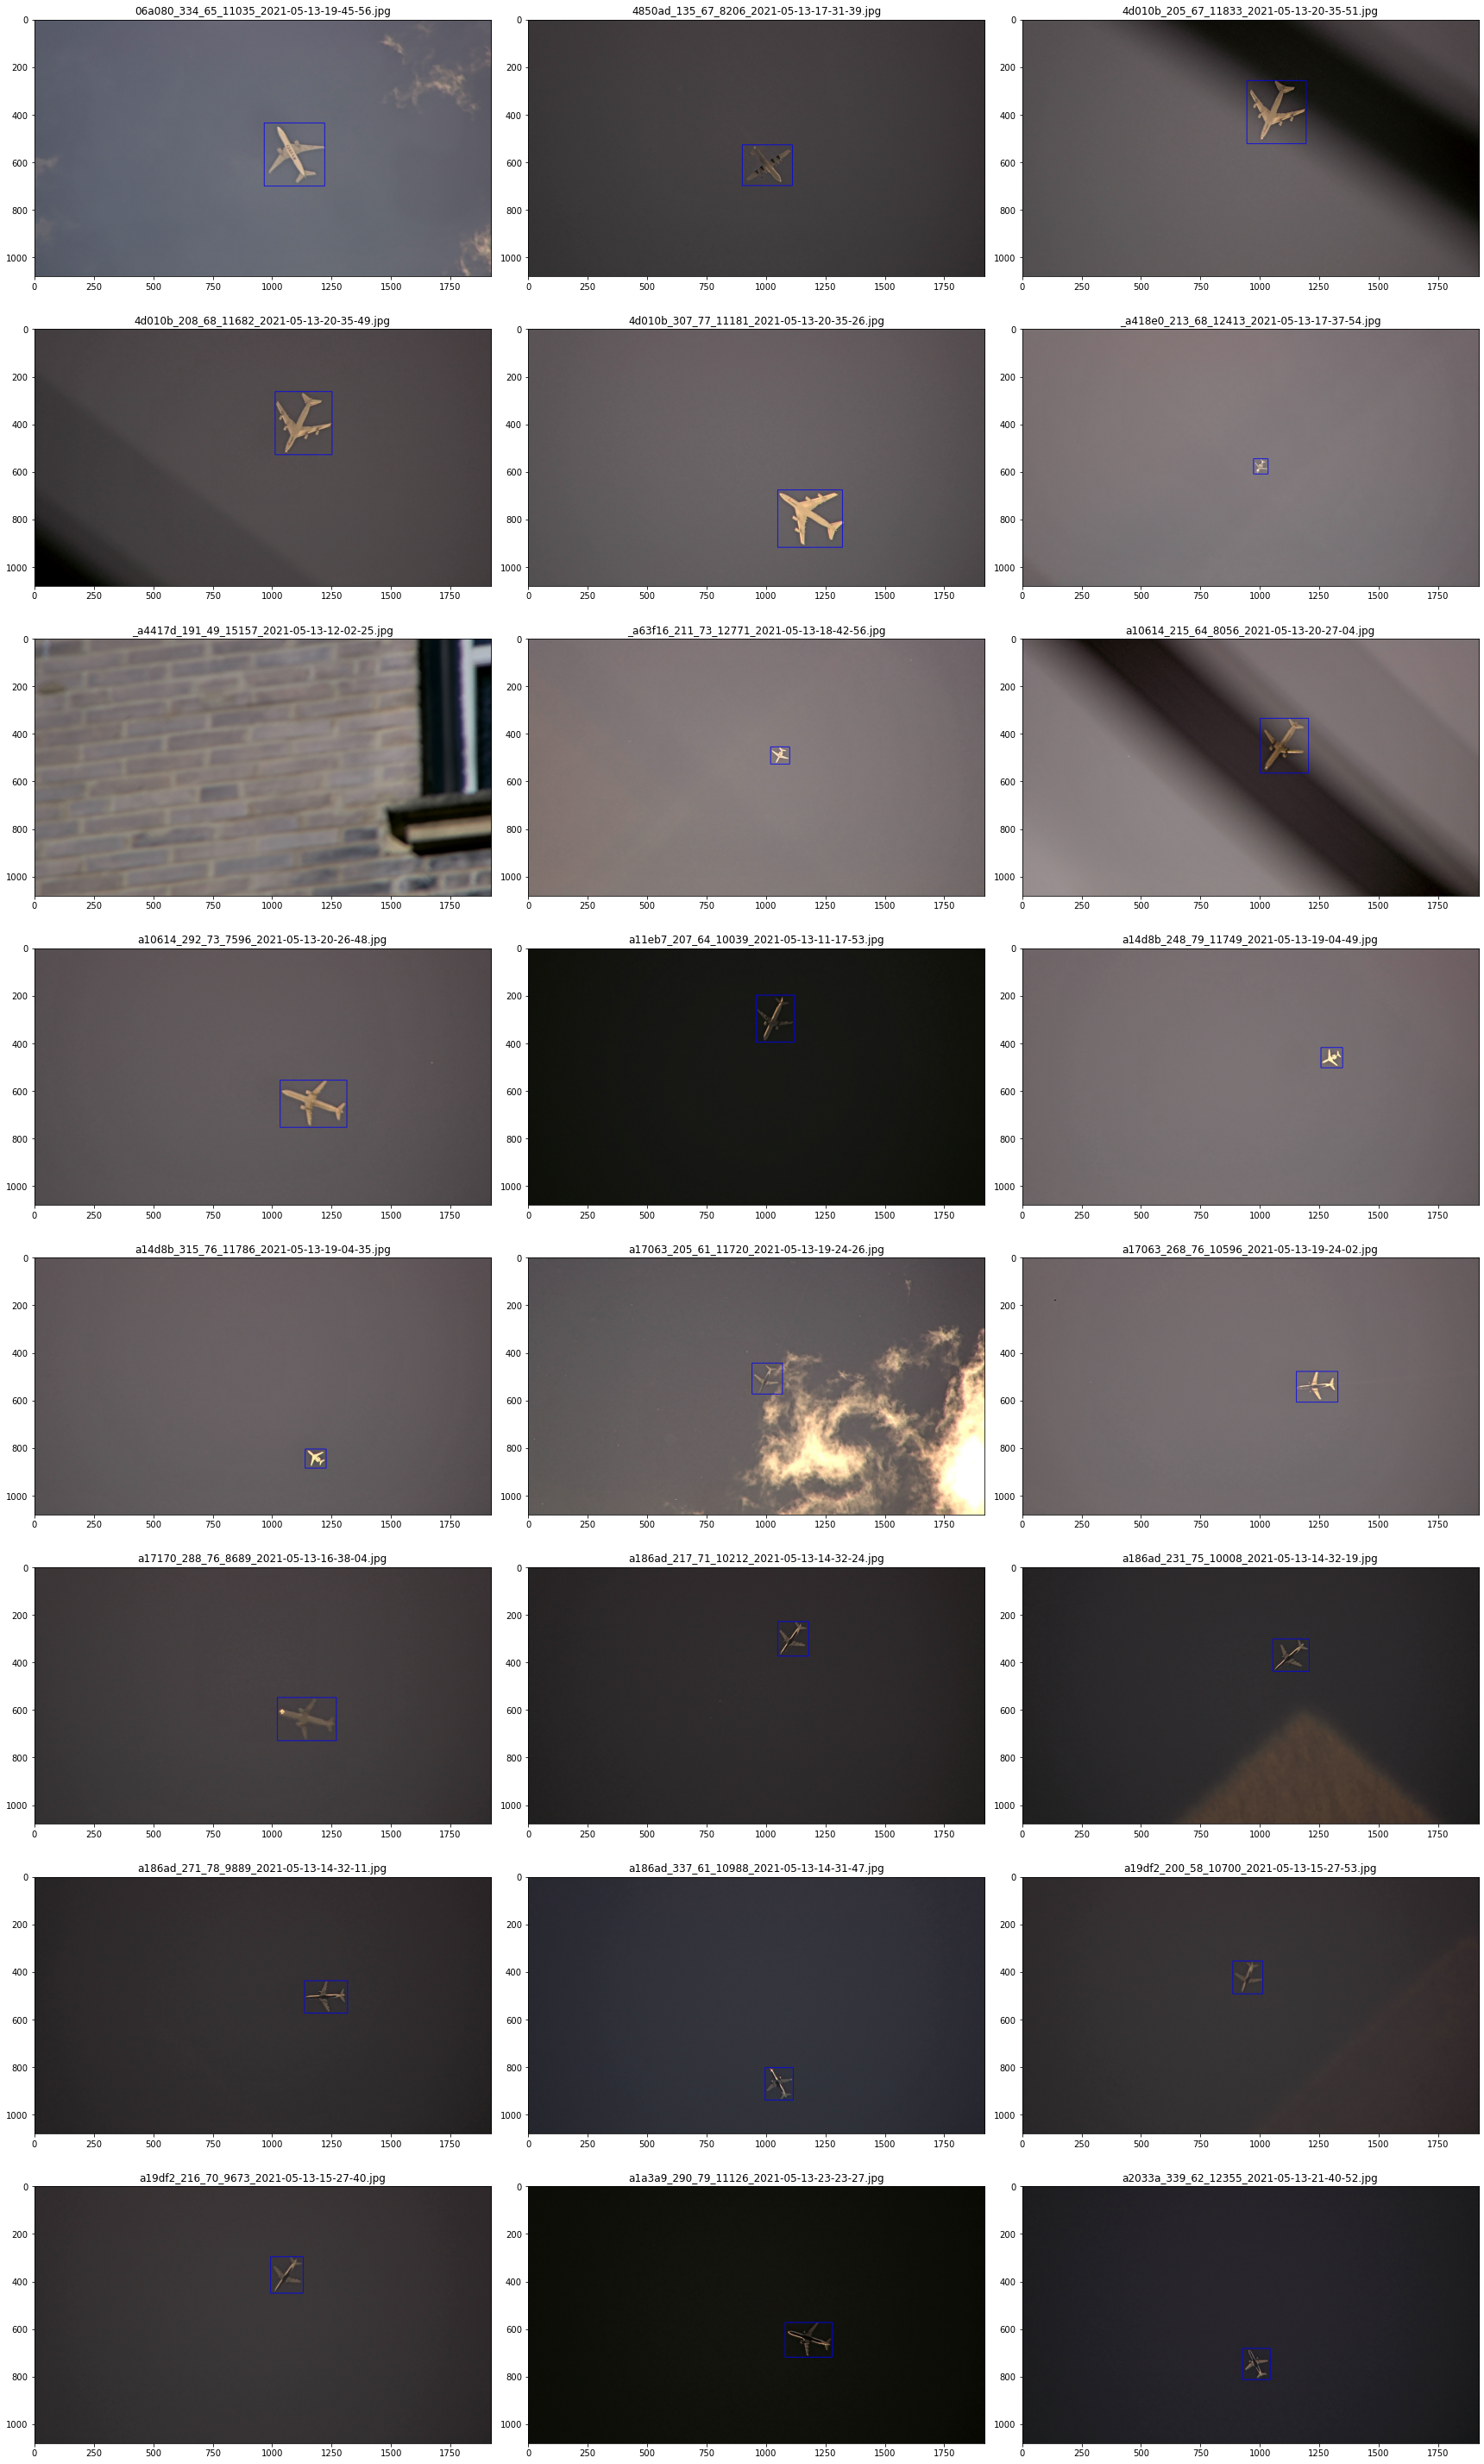

In [11]:
# make plots
outname = 'skyscan_binary' 
detection_thresh = 0.5
#         plot_dir = 'pred_plots_' + str(detection_thresh).replace('.', 'p')
plot_dir = os.path.join(yoltv4_path, 'darknet', 'results', 
                        outname, 'pred_plots_' + str(detection_thresh).replace('.', 'p'))
out_path = os.path.join(yoltv4_path, 'darknet', 'results', 
                        outname, 'yoltv4_test_set_prediction_mosaic_thresh=' + str(detection_thresh).replace('.', 'p') + '.jpg')
print('plot_dir:', plot_dir)
print("output plot file:", out_path)
# visualize some of the yolt labels
dir_tmp = plot_dir
rows, cols = 8, 3
figsize = 8, 5
paths_tmp = sorted([os.path.join(dir_tmp, j) for j in os.listdir(dir_tmp)])
rand_selection = paths_tmp[:rows*cols] 
# rand_selection = random.sample(paths_tmp, rows*cols)
fig, axes = plt.subplots(nrows=rows, ncols=cols,  figsize=(figsize[0]*cols, figsize[1]*rows))
for i in range(rows*cols):
    ax = axes.flatten()[i]
    im_path_tmp = rand_selection[i]
    im_name_tmp = os.path.basename(im_path_tmp)
    im = skimage.io.imread(im_path_tmp)
    ax.imshow(im)
    ax.set_title(im_name_tmp)

plt.tight_layout()
plt.savefig(out_path, dpi=250)
plt.show()